In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
df = pd.read_csv('train_BRCpofr.csv')
df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


Os dados podem ser econtrados [aqui](https://www.kaggle.com/datasets/shibumohapatra/customer-life-time-value?select=train_BRCpofr.csv)

id-Unique identifier of a customer  
gender-Gender of the customer   
area-Area of the customer   
qualification-Highest Qualification of the customer     
income-Income earned in a year (in rupees)  
marital_status-Marital Status of the customer {0:Single, 1: Married}    
vintage-No. of years since the first policy date    
claim_amount-Total Amount Claimed by the customer (in rupees)   
num_policies-Total no. of policies issued by the customer   
policy-Active policy of the customer    
type_of_policy-Type of active policy    
cltv- Customer lifetime value (Target Variable) 

# EDA

In [34]:
print(df.shape)
print(df.isna().sum())

(89392, 12)
id                0
gender            0
area              0
qualification     0
income            0
marital_status    0
vintage           0
claim_amount      0
num_policies      0
policy            0
type_of_policy    0
cltv              0
dtype: int64


In [35]:
for column in df.columns:
    if column == 'id' or column == 'claim_amount' or column == 'cltv':
        pass
    else:
        print(f'{column}:  {df[column].unique()}')

gender:  ['Male' 'Female']
area:  ['Urban' 'Rural']
qualification:  ['Bachelor' 'High School' 'Others']
income:  ['5L-10L' 'More than 10L' '2L-5L' '<=2L']
marital_status:  [1 0]
vintage:  [5 8 7 6 1 0 3 4 2]
num_policies:  ['More than 1' '1']
policy:  ['A' 'C' 'B']
type_of_policy:  ['Platinum' 'Gold' 'Silver']


Logo de cara imagino que para o type of policy eu possa usar o Ordinal Encoder, já que acredito que existirá uma relação positiva entre o tipo e o cltv. Claro que irei confirmar primeiro.     
Já para as outras variáveis categóricas, será necessário aprofundar em cada uma.

Uma das primeiras coisas que me chamou atenção quando abri o df foi a questão do income estar sendo passado como range, então primeiro irei explorar apenas ele para decidir como prosseguir

In [36]:
incomes_counts_policy = df.groupby(['income', 'type_of_policy'])['income'].count()
incomes_counts_policy

income         type_of_policy
2L-5L          Gold               4462
               Platinum          10908
               Silver             5788
5L-10L         Gold              12544
               Platinum          28610
               Silver            11562
<=2L           Gold                294
               Platinum           1042
               Silver              518
More than 10L  Gold               3286
               Platinum           7236
               Silver             3142
Name: income, dtype: int64

In [37]:
incomes_counts = df.groupby('income')['income'].count()
incomes_counts

income
2L-5L            21158
5L-10L           52716
<=2L              1854
More than 10L    13664
Name: income, dtype: int64

<AxesSubplot: xlabel='income'>

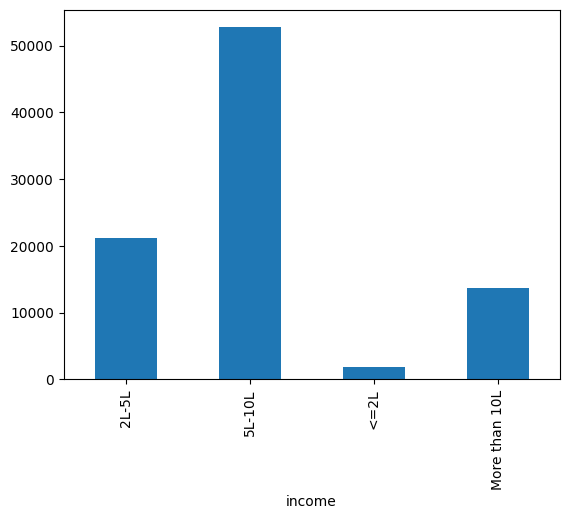

In [38]:
incomes_counts.plot(kind='bar')

<AxesSubplot: xlabel='income,type_of_policy'>

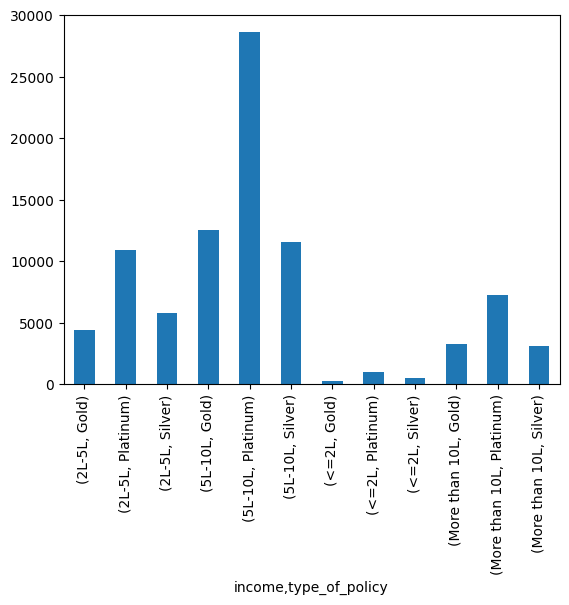

In [39]:
incomes_counts_policy.plot(kind='bar')

Podemos notar que em todos os o tipo seguro que predodomina é o platina.

In [40]:
cltv_by_income_policy = df.groupby(['income', 'type_of_policy'])['cltv'].sum()
cltv_by_income_policy

income         type_of_policy
2L-5L          Gold               491606004
               Platinum          1233512532
               Silver             590992884
5L-10L         Gold              1227635064
               Platinum          2762199048
               Silver            1021449360
<=2L           Gold                31918116
               Platinum           117362148
               Silver              57337164
More than 10L  Gold               294718320
               Platinum           654718764
               Silver             272749884
Name: cltv, dtype: int64

<AxesSubplot: xlabel='income,type_of_policy'>

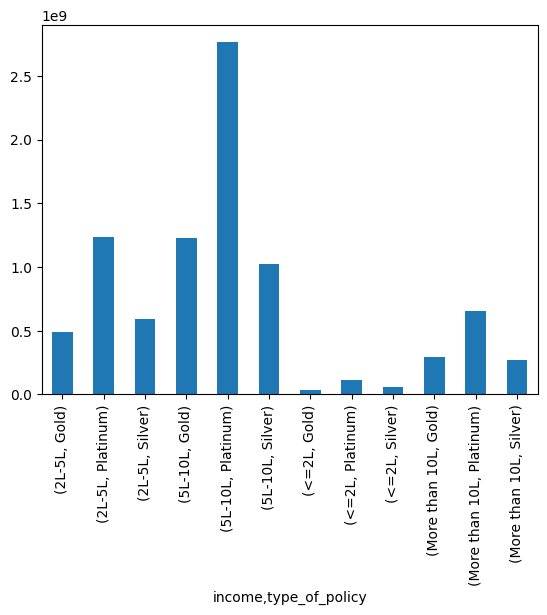

In [41]:
cltv_by_income_policy.plot(kind='bar')

Também como era de se imaginar são os que tem um cltv maior também.

In [42]:
df.groupby(['income', 'type_of_policy'])['cltv'].median()

income         type_of_policy
2L-5L          Gold              67518.0
               Platinum          69132.0
               Silver            67386.0
5L-10L         Gold              66240.0
               Platinum          66120.0
               Silver            64884.0
<=2L           Gold              66504.0
               Platinum          68874.0
               Silver            66174.0
More than 10L  Gold              65490.0
               Platinum          65670.0
               Silver            65634.0
Name: cltv, dtype: float64

<AxesSubplot: xlabel='income', ylabel='cltv'>

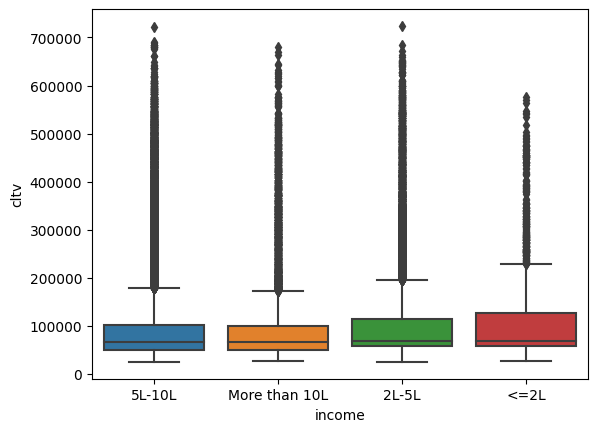

In [43]:
sns.boxplot(data=df, x='income', y='cltv')

<AxesSubplot: xlabel='income', ylabel='cltv'>

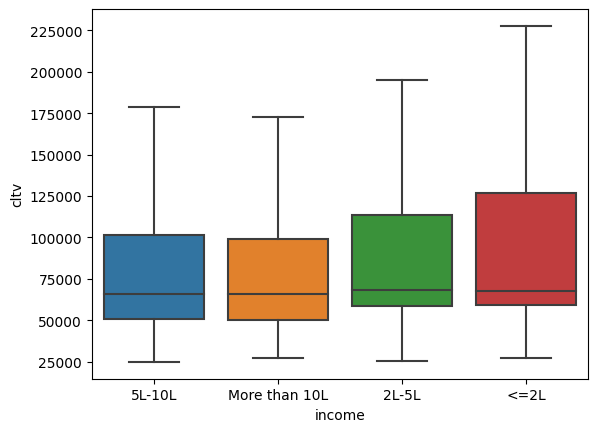

In [44]:
sns.boxplot(data=df, x='income', y='cltv', showfliers=False)

Incialmente os outliers assustam, mas podemos ficar mais "tranquilos" se levarmos em consideração à fórmula de como são encontrados os mesmos: [Q1 - k (Q3 - Q1), Q3 + k(Q3-Q1)]    
O que significa que a mediana junto com os quartis tem uma forte influencia.    
Como estamos falando de seguro eu presumo que isso ocorra porque a maior parte dos carros que circulam em qualquer cidade são populares, fazendo assim com que não tenham um custo de seguro tão elevado, o que faz com que existam médias realmente diferentes entre cada tipo de seguro ou renda, mas a mediana tende a se aproxima seguindo  a lógica de carros populares.
Mesmo assim vamos precisar verificar mais a fundo alguns valores.

In [45]:
np.percentile(df['cltv'], 75)

103440.0

In [46]:
df.query('cltv <= 103440.0')

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736
7,8,Female,Urban,High School,5L-10L,0,0,5473,More than 1,A,Silver,64128
...,...,...,...,...,...,...,...,...,...,...,...,...
89385,89386,Male,Urban,Bachelor,5L-10L,1,4,3138,More than 1,A,Gold,96672
89386,89387,Male,Urban,High School,5L-10L,1,0,5744,1,A,Platinum,59688
89387,89388,Male,Rural,High School,More than 10L,0,6,0,More than 1,B,Platinum,95736
89388,89389,Male,Urban,Bachelor,5L-10L,1,0,3897,More than 1,A,Platinum,67596


In [47]:
df.query('cltv > 103440.0')

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
5,6,Male,Rural,High School,More than 10L,1,1,0,1,C,Gold,348768
6,7,Female,Rural,Bachelor,5L-10L,1,6,0,More than 1,A,Gold,238920
13,14,Male,Urban,Bachelor,2L-5L,1,1,4615,More than 1,C,Silver,133344
19,20,Female,Urban,Bachelor,More than 10L,1,2,7541,More than 1,A,Platinum,110568
...,...,...,...,...,...,...,...,...,...,...,...,...
89380,89381,Male,Urban,High School,2L-5L,1,1,9885,More than 1,A,Silver,164004
89383,89384,Female,Rural,High School,5L-10L,0,8,6664,More than 1,A,Silver,199056
89384,89385,Female,Rural,Bachelor,2L-5L,0,7,0,More than 1,B,Platinum,171828
89389,89390,Female,Urban,Bachelor,5L-10L,0,4,3363,More than 1,B,Platinum,114120


Realmente podemos ver que usando o 3 quartil é possível notar que existem 3 vezes mais dados de um do que do outro. Vamos tentar realmente encontrar outliers.

Segundo pesquisa o valor médio de um seguro no Brasil está em 4014,31. Veja [aqui](https://investnews.com.br/economia/preco-de-seguro-de-carro-2022/#:~:text=Os%20números%20mostram%20que%2C%20em,para%20R%24%204.014%2C31.).   
Então vamos fazer algumas conversões de valores para descobrir o que é aceitável e o que não.   
No dia 03/03/2023 1 real é equivalente a 15,76 Rupia  indiana. 4014,31 * 15,76 = 63273,99.      
63273,99 * 12 = 759.287,88      
Usando esses valores como base podemos ter uma noção do que pode ser um outlier na vida real.

In [48]:
df.query('cltv > 750000')

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv


Seguindo a lógica usada, não parece realmente que existe algum outlier.

<AxesSubplot: xlabel='vintage', ylabel='claim_amount'>

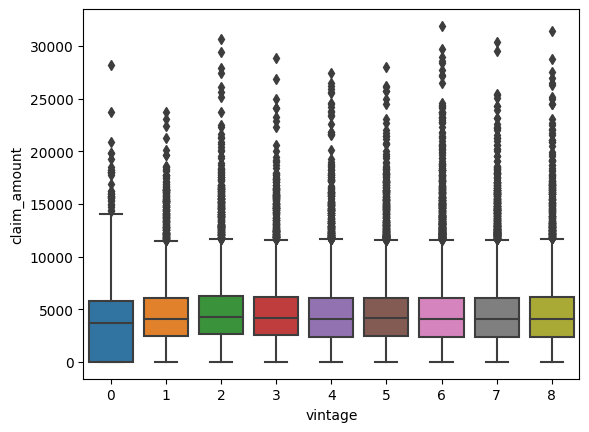

In [49]:
sns.boxplot(data=df, x='vintage', y='claim_amount')

Olhando os dados fiquei curioso se poderia haver algum outlier na questão de quanto a pessoa pegou de seguro, mas podemos ver que segue o mesmo padrão da outra análise

## Análise de distribuição/dispersão

In [54]:
qualitative_labels = df.drop(['vintage', 'claim_amount', 'cltv', 'id'], axis=1)
qualitative_labels.head()

,gender,area,qualification,income,marital_status,num_policies,policy,type_of_policy
0,Male,Urban,Bachelor,5L-10L,1,More than 1,A,Platinum
1,Male,Rural,High School,5L-10L,0,More than 1,A,Platinum
2,Male,Urban,Bachelor,5L-10L,1,More than 1,A,Platinum
3,Female,Rural,High School,5L-10L,0,More than 1,A,Platinum
4,Male,Urban,High School,More than 10L,1,More than 1,A,Gold


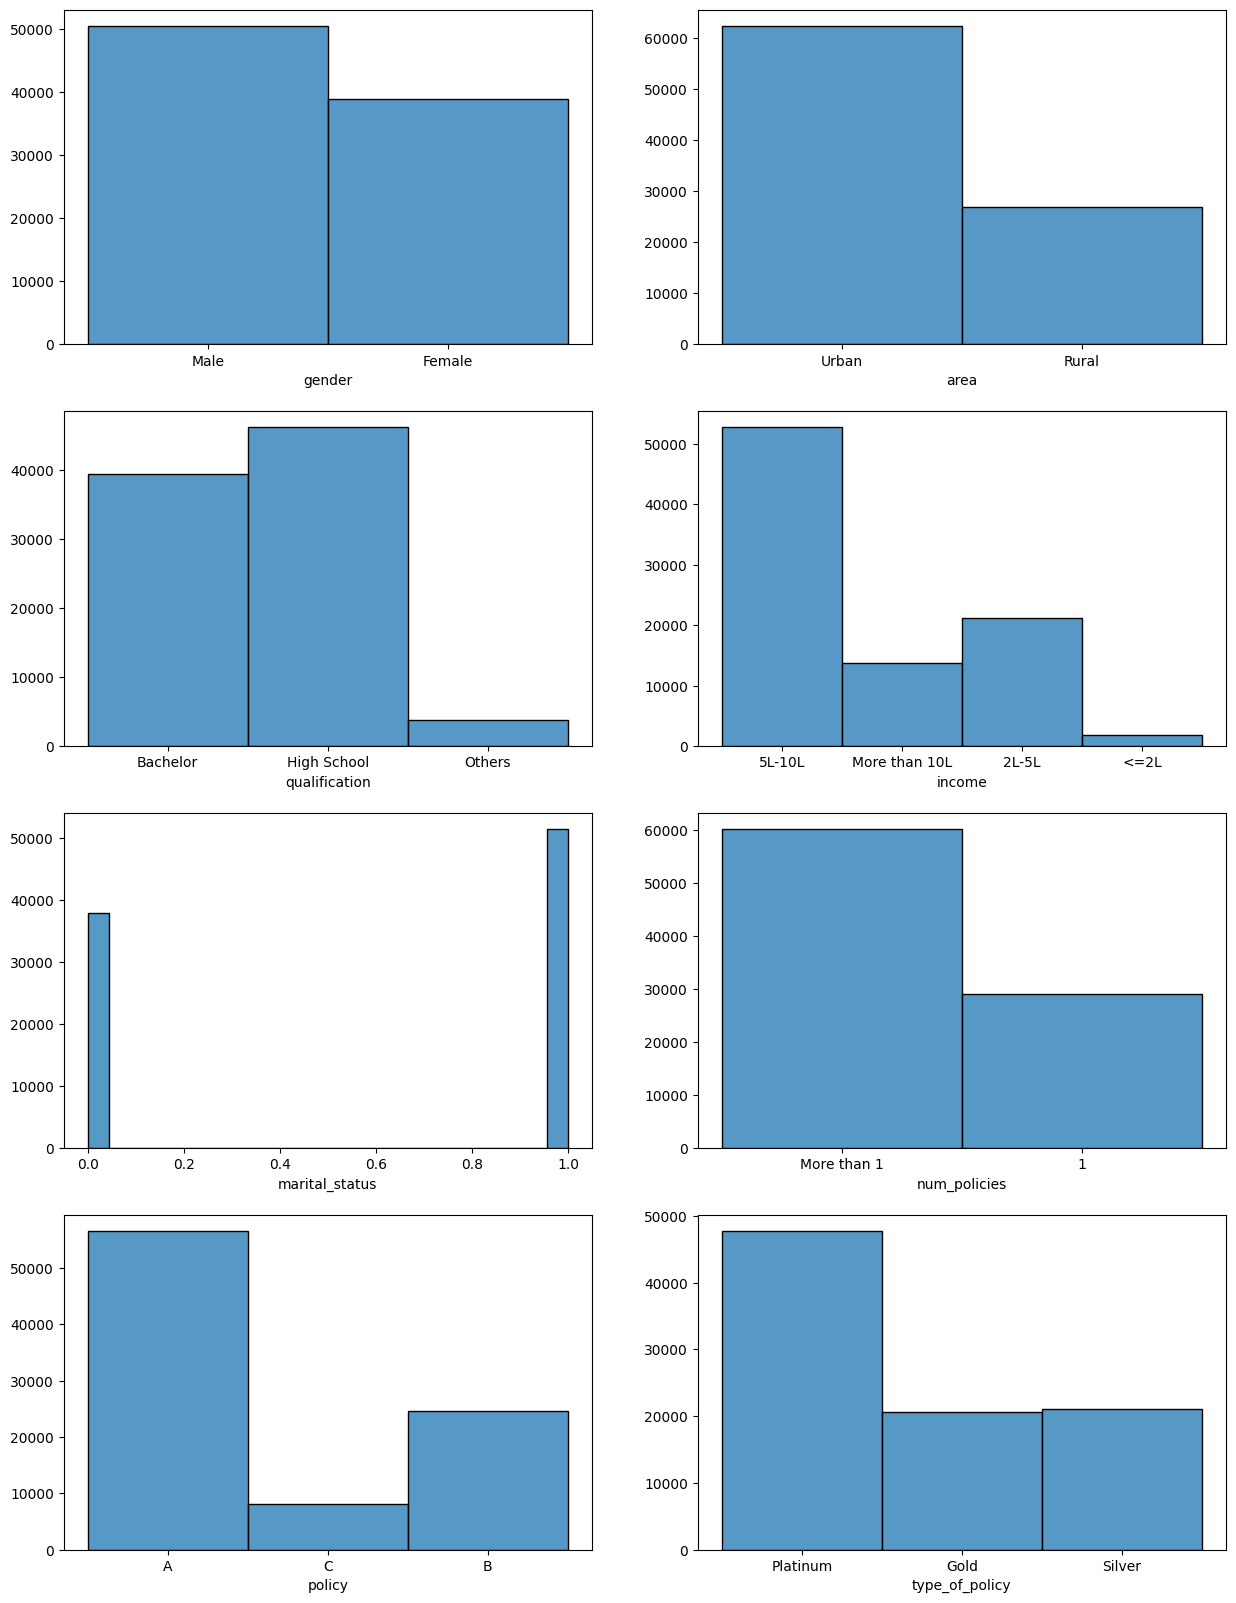

In [55]:
plt.figure(figsize=(15,20))
for i, column in enumerate(qualitative_labels.columns):
    plt.subplot(4, 2, i+1)
    sns.histplot(qualitative_labels[column])
    plt.ylabel('')

O único que realmente me chamou atenção foi o número de apólices, achei que 1 por pessoa seria o predominante. Mas levando em conta que a maioria das pessoas são cadas e que muitas vezes a família faz todos os seguros no nome de uma única pessoa, parece ser algo possível de se acreditar. Vamos dar uma breve verificada.

In [61]:
df.groupby(['num_policies', 'marital_status'])['num_policies'].count()

num_policies  marital_status
1             0                 10660
              1                 18469
More than 1   0                 27288
              1                 32975
Name: num_policies, dtype: int64

In [76]:
import math
from scipy.stats import norm

casados = 32975
solteiros = 27288
size = casados + solteiros

p1 = casados/size
p2 = solteiros/size

erro_padrao = math.sqrt((p1 * (1 - p1) / size) + (p2 * (1 - p2) / size))

z = (p1 - p2) / erro_padrao

alpha = 0.05

critical_value = norm.ppf(1 - alpha / 2)

abs(z) > critical_value

True

O código acima seria um cálculo de teste de hipótese, como não tenho um conhecimento profundo em estatística não sei dizer se realizei da maneira correta. Mas levando em conta a análise feita e o cálculo vou considerar que realmente existe uma diferença para pessoas casadas ou não e o número de apólices.

In [79]:
quantitative_labels = df[['vintage', 'claim_amount', 'cltv']]
quantitative_labels.head()

,vintage,claim_amount,cltv
0,5,5790,64308
1,8,5080,515400
2,8,2599,64212
3,7,0,97920
4,6,3508,59736


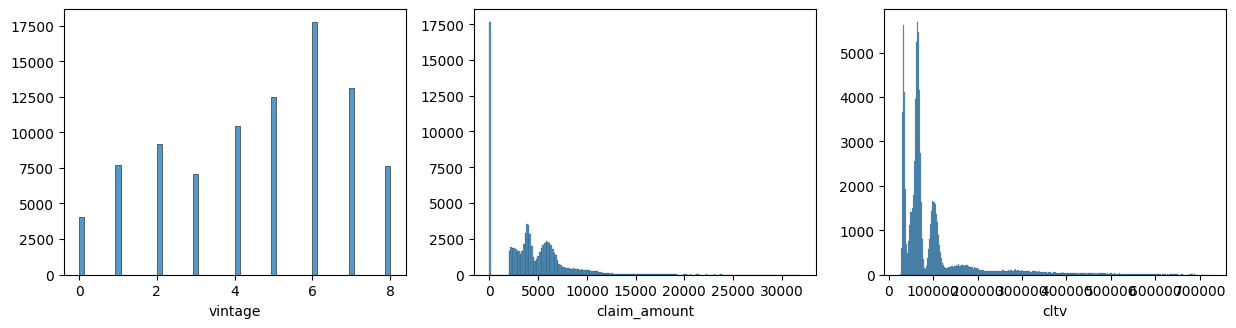

In [80]:
plt.figure(figsize=(15,20))
for i, column in enumerate(quantitative_labels.columns):
    plt.subplot(5, 3, i+1)
    sns.histplot(quantitative_labels[column])
    plt.ylabel('')

Podemos ver que nenhum segue uma distribuição em forma de normal, pode ser interassante fazer alguma transformação para o treinamento do modelo. Mas isso vamos verificar mais a frente.

O que também podemos ver é que a maioria das pessoas não faz um claim, o que para a seguradora é algo bom

# Pré-processamento/Feature selection

In [81]:
df.head()

,id,gender,area,qualification,income,marital_status,vintage,claim_amount,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,5,5790,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,8,5080,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,8,2599,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,7,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,6,3508,More than 1,A,Gold,59736


A primeira coisa que irei fazer será retirar o vintage e o claim_amnount.   
Vamos pensar em um caso real. A empresa lhe contrata para que você faça a previsão do possível cltv de novos clientes, e diversas informações serão obtidas, mas não é possível se perguntar para o cliente quantos anos ele permanecerá sendo cliente. E também não conseguimos saber quanto que ele irá usar do seguro. Logo vemos que essas features se tratam do futuro.    
O que poderia ser uma opção é pegar os valores de antigas apólices caso o cliente tenha, mesmo que seja com outras seguradoras.

In [82]:
df.drop(['vintage', 'claim_amount'], axis=1)

,id,gender,area,qualification,income,marital_status,num_policies,policy,type_of_policy,cltv
0,1,Male,Urban,Bachelor,5L-10L,1,More than 1,A,Platinum,64308
1,2,Male,Rural,High School,5L-10L,0,More than 1,A,Platinum,515400
2,3,Male,Urban,Bachelor,5L-10L,1,More than 1,A,Platinum,64212
3,4,Female,Rural,High School,5L-10L,0,More than 1,A,Platinum,97920
4,5,Male,Urban,High School,More than 10L,1,More than 1,A,Gold,59736
...,...,...,...,...,...,...,...,...,...,...
89387,89388,Male,Rural,High School,More than 10L,0,More than 1,B,Platinum,95736
89388,89389,Male,Urban,Bachelor,5L-10L,1,More than 1,A,Platinum,67596
89389,89390,Female,Urban,Bachelor,5L-10L,0,More than 1,B,Platinum,114120
89390,89391,Female,Rural,High School,2L-5L,0,More than 1,B,Platinum,71772
